## note on 2020.1.30
1. Du's operational only has motion vection, no advection function
2. RainyMotion is 3 times faster than Du's code
3. Du's motion vector is relatively slow, may fail in typhoon season

In [67]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())
import wradlib.ipol as ipol
from collections import OrderedDict
from datetime import datetime,timedelta
from rainymotion import models, metrics, utils
import joblib
import pandas as pd
data_folder = "/Users/jiang/data/jma_radar"
daily_folder = "/Users/jiang/data/jma_radar/2019_daily_unit8"
#daily_folder = "/Users/jiang/data/jma_radar"

/Users/jiang/github_all/rainymotion/docs/notebooks


## check a specific datetime
- only threat score

In [68]:
time_step = 5 * 60 # seconds
threshold = 0.1  # mm/h
dt = datetime(2019, 9, 8, 15, 20)
dt_now = dt + timedelta(seconds = time_step)
dt_12  = dt + timedelta(seconds = time_step * 13)
yday_str = dt.strftime('%Y_%m_%d')
yday_now = dt_now.strftime('%Y_%m_%d')
yday_12  = dt_12.strftime('%Y_%m_%d')

daily_database = {}
inputs = np.zeros(shape = (2,1000,1000), dtype = np.float16)
if yday_str not in daily_database:
    daily_database[yday_str] = joblib.load(os.path.join(daily_folder, 
                                                        f"jma_radar_uint8_{yday_str}.joblib")) 
if yday_12 not in daily_database:
    daily_database[yday_12]  = joblib.load(os.path.join(daily_folder,
                                                        f"jma_radar_uint8_{yday_12}.joblib")) 

sequence_in_day = int(dt.hour*12 + (dt.minute)/5)    
inputs[0,:,:] = daily_database[yday_str][sequence_in_day]/10.0
inputs[1,:,:] = daily_database[yday_now][(sequence_in_day + 1)%288]/10.0
up_lmt = np.max(inputs)
im0 = inputs[0,:,:].astype(np.float32) / up_lmt * 255
im1 = inputs[1,:,:].astype(np.float32) / up_lmt * 255

In [69]:
import json
with open("./config/prec/running.json", 'r') as f:
    param = json.load(f)

param['io']['raw_size'] = tuple(param['io']['raw_size'])
param['io']['downsample_size'] = tuple(param['io']['downsample_size'])
if param['img_fig']['figsize'] is not None:
    param['img_fiwg']['figsize'] = tuple(param['img_fig']['figsize'])
if param['vector_fig']['figsize'] is not None:
    param['vector_fig']['figsize'] = tuple(param['vector_fig']['figsize'])
param['hs']['smooth']['threshold'] = np.quantile(im0[im0 > 1e-3], .2)

In [70]:
%%time
from src import of as optical_flow
of = getattr(optical_flow, 'PyramidHornSchunck')(**param['hs']['basic'])
of(im1, im0)

for m in param['hs']['smooth']['methods']:
    of.smooth_vel(mode=m, **param['hs']['smooth'])
u, v = of.u.copy(), of.v.copy()
u *= param['hs']['basic']['dx']
v *= param['hs']['basic']['dy']

lead_steps = 13
coord_source_i, coord_source_j = np.meshgrid(range(u.shape[1]),range(u.shape[0]))
coord_targets = []
for lead_step in range(lead_steps):
    coord_target_i = coord_source_i + u * (lead_step )
    coord_target_j = coord_source_j + v * (lead_step )
    coord_targets.append([coord_target_i, coord_target_j])
coord_source = [coord_source_i, coord_source_j]
nowcasts = []
# interpolation
for lead_step in range(lead_steps):
    nowcasts.append(models._interpolator(inputs[1,:,:], coord_source, coord_targets[lead_step], method = "idw"))
# reshaping
nowcasts = np.moveaxis(np.dstack(nowcasts), -1, 0)
du = nowcasts

CPU times: user 54 s, sys: 1.28 s, total: 55.3 s
Wall time: 17.6 s


In [71]:
if False:
    plt.figure(dpi=150)
    plt.imshow(im1, cmap='jet',vmin=1, vmax= 50, origin = "lower")
    plt.colorbar(label="radar intensity")
    X,Y = range(1000),range(1000)
    skip = 30  # orginal 10
    plt.quiver(X[::skip], Y[::skip], u[::skip,::skip], v[::skip,::skip],
               scale = 30,color='red',headwidth = 5)
    plt.title("motion field overlaps radar image")
    plt.show()

In [72]:
%%time
model = models.Dense()    
model.input_data = inputs
model.lead_steps = 13
nowcast = model.run()  # shape (13, 1000, 1000)

CPU times: user 35.3 s, sys: 425 ms, total: 35.7 s
Wall time: 5.57 s


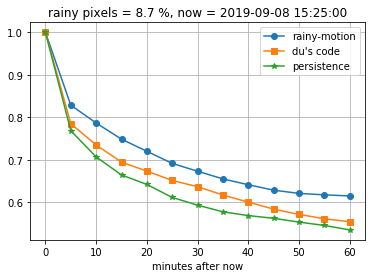

In [73]:
threat_rm = []  # threat score
threat_du = []
threat_per = []

dt_predit = dt_now 
yday_pre = dt_predit.strftime('%Y_%m_%d')
sequence = int(dt_predit.hour*12 + (dt_predit.minute)/5)   
ground_truth0 =  daily_database[yday_pre][sequence]/10.0

lead_time = list(range(0,65,5))
for i in range (13):
    dt_predit = dt_now + timedelta(seconds = time_step * i)
    yday_pre = dt_predit.strftime('%Y_%m_%d')
    sequence = int(dt_predit.hour*12 + (dt_predit.minute)/5)   
    ground_truth =  daily_database[yday_pre][sequence]/10.0
    threat_rm.append(metrics.CSI(ground_truth,nowcast[i], threshold = threshold))
    threat_du.append(metrics.CSI(ground_truth,du[i], threshold = threshold))
    threat_per.append(metrics.CSI(ground_truth,ground_truth0, threshold = threshold))
plt.plot(lead_time, threat_rm,'o-',label = "rainy-motion")
plt.plot(lead_time, threat_du,'s-',label = "du's code")
plt.plot(lead_time, threat_per,'*-',label = "persistence")
plt.title(f"rainy pixels = {np.sum(ground_truth0 >= threshold)/(1e6 - 132396) *100 :.1f} %, now = {dt_now}")
plt.xlabel("minutes after now")
plt.legend()
plt.grid()
plt.show()

## make time sequence images and add score

In [11]:
hh = str(dt_now.hour).zfill(2) 
mm = str(dt_now.minute).zfill(2)
for i in range (13):
    dt_predit = dt_now + timedelta(seconds = time_step * i)
    yday_pre = dt_predit.strftime('%Y_%m_%d')
    sequence = int(dt_predit.hour*12 + (dt_predit.minute)/5)   
    ground_truth =  daily_database[yday_pre][sequence]/10.0
    hits, misses, falsealarms, _ = metrics.prep_clf(ground_truth, du[i], threshold = threshold)

    threat =  hits / (hits + misses + falsealarms)
    recall =  hits / (hits + misses)
    precision = hits / (hits + falsealarms)
    
    plt.figure(dpi = 100)
    
    image1 = ground_truth
    image2 = du[i]
    plt.imshow(np.log(image1 + 0.01),cmap = 'Reds',origin = "lower")
    plt.imshow(np.log(image2 + 0.01).astype('float32'),cmap = 'Blues',origin = "lower",alpha = 0.5)
    plt.title(f"now = {yday_now}-{hh}:{mm} UTC,+{str(i*5).zfill(2)}min")
    plt.text(20, 950, f"rainy pixels = {np.sum(image1 >= threshold)/(1e6 - 132396) *100 :.1f} %")
    plt.text(20, 900, f"threshold = {threshold} mm/h")
    plt.text(20, 850, f"threat = {threat:.2f}")
    plt.text(20, 800, f"recall = {recall:.2f}")
    plt.text(20, 750, f"precision = {precision:.2f}")
    plt.text(20, 700, "Truth(Reds)",color = "red")
    plt.text(20, 650, "Forecast(Blues)",color = "blue")
    plt.grid()
    plt.tight_layout(h_pad=0.5)
    plt.savefig("JMA_rainymotion_image_score" + str(i).zfill(2) + ".png",format = "png",bbox_inches='tight')
    plt.close()

In [ ]:
import imageio
png_files = glob.glob("./JMA_rainymotion_image_score*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
    os.system(f"rm -r {filename}")
#output_file = f'JMA_rainymotion_image_score-{yday_now}.gif'
output_file = f'JMA_du_image_score-{yday_now}.gif'
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

### generate rainymotion result to compare

In [13]:
time_step = 5 * 60 # seconds
threshold = 0.1  # mm/h
#dt = datetime(2020, 1, 27 , 0, 0)
dt_now = dt + timedelta(seconds = time_step)
dt_12  = dt + timedelta(seconds = time_step * 13)
yday_str = dt.strftime('%Y_%m_%d')
yday_now = dt_now.strftime('%Y_%m_%d')
yday_12  = dt_12.strftime('%Y_%m_%d')
hh = str(dt_now.hour).zfill(2) 
mm = str(dt_now.minute).zfill(2)

daily_database = {}
inputs = np.zeros(shape = (2,1000,1000), dtype = np.float16)
if yday_str not in daily_database:
    daily_database[yday_str] = joblib.load(os.path.join(daily_folder, 
                                                        f"jma_radar_uint8_{yday_str}.joblib")) 
if yday_12 not in daily_database:
    daily_database[yday_12]  = joblib.load(os.path.join(daily_folder,
                                                        f"jma_radar_uint8_{yday_12}.joblib")) 

sequence_in_day = int(dt.hour*12 + (dt.minute)/5)    
inputs[0,:,:] = daily_database[yday_str][sequence_in_day]/10.0
inputs[1,:,:] = daily_database[yday_now][(sequence_in_day+1)%288]/10.0
    
model = models.Dense()    
model.input_data = inputs
model.lead_steps = 13
nowcast = model.run()  # shape (13, 1000, 1000)

for i in range (13):
    dt_predit = dt_now + timedelta(seconds = time_step * i)
    yday_pre = dt_predit.strftime('%Y_%m_%d')
    sequence = int(dt_predit.hour*12 + (dt_predit.minute)/5)   
    ground_truth =  daily_database[yday_pre][sequence]/10.0
    hits, misses, falsealarms, _ = metrics.prep_clf(ground_truth,nowcast[i], threshold = threshold)
    #dense_13_th.append(metrics.CSI(ground_truth,nowcast[i], threshold = threshold))
    threat =  hits / (hits + misses + falsealarms)
    recall =  hits / (hits + misses)
    precision = hits / (hits + falsealarms)
    
    plt.figure(dpi = 100)
    
    image1 = ground_truth
    image2 = nowcast[i]
    plt.imshow(np.log(image1 + 0.01),cmap = 'Reds',origin = "lower")
    plt.imshow(np.log(image2 + 0.01).astype('float32'),cmap = 'Blues',origin = "lower",alpha = 0.5)
    plt.title(f"now = {yday_now}-{hh}:{mm} UTC,+{str(i*5).zfill(2)}min")
    plt.text(20, 950, f"rainy pixels = {np.sum(image1 >= threshold)/(1e6 - 132396) *100 :.1f} %")
    plt.text(20, 900, f"threshold = {threshold} mm/h")
    plt.text(20, 850, f"threat = {threat:.2f}")
    plt.text(20, 800, f"recall = {recall:.2f}")
    plt.text(20, 750, f"precision = {precision:.2f}")
    plt.text(20, 700, "Truth(Reds)",color = "red")
    plt.text(20, 650, "Forecast(Blues)",color = "blue")
    plt.grid()
    plt.tight_layout(h_pad=0.5)
    plt.savefig("JMA_rainymotion_image_score" + str(i).zfill(2) + ".png",format = "png",bbox_inches='tight')
    plt.close()

## make gif animiation and delete png images

In [14]:
import imageio
png_files = glob.glob("./JMA_rainymotion_image_score*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
    os.system(f"rm -r {filename}")
output_file = f'JMA_rainymotion_image_score-{yday_now}.gif'
#output_file = f'JMA_du_image_score-{yday_now}.gif'
imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

13


## du vs rainymotion in frame-to-frame comparison

In [70]:
hh = str(dt_now.hour).zfill(2) 
mm = str(dt_now.minute).zfill(2)
for i in range (13):   
    plt.figure(dpi = 100)
    image1 = nowcast[i].astype('float32')
    image2 = du[i]
    plt.imshow(np.log(image1 + 0.01),cmap = 'Reds',origin = "lower")
    plt.imshow(np.log(image2 + 0.01).astype('float32'),cmap = 'Blues',origin = "lower",alpha = 0.5)
    plt.title(f"now = {yday_now}-{hh}:{mm} UTC,+{str(i*5).zfill(2)}min")

    plt.text(20, 700, "rainymotion (Reds)",color = "red")
    plt.text(20, 650, "du's code + advection(Blues)",color = "blue")
    plt.grid()
    plt.tight_layout(h_pad=0.5)
    plt.savefig("JMA_rainymotion_image_score" + str(i).zfill(2) + ".png",format = "png",bbox_inches='tight')
    plt.close()

In [71]:
import imageio
png_files = glob.glob("./JMA_rainymotion_image_score*.png")
png_files.sort()
print(len(png_files)) # 288

images = []
for filename in png_files:
    images.append(imageio.imread(filename))
    os.system(f"rm -r {filename}")
# output_file = f'JMA_rainymotion_image_score-{yday_now}.gif'
# output_file = f'JMA_du_image_score-{yday_now}.gif'
output_file = f'JMA_rainymotion_vs_du-{yday_now}.gif'

imageio.mimsave(output_file, images,duration = 1)  # unit is in seconds

13
